In [1]:
import torch
from bertviz import head_view
from transformers import MT5TokenizerFast, MT5ForConditionalGeneration
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

from overfit_attention import prepare_text_input


In [2]:
# Some features are shared among all models
shortest_article_ids = [260, 1301, 2088, 665, 1572, 436, 1887, 1422, 1506, 474]

dataset = load_dataset("dennlinger/klexikon")
tokenizer = MT5TokenizerFast.from_pretrained("google/mt5-small")

for idx in shortest_article_ids:
    # Load index-specific model
    model = MT5ForConditionalGeneration.from_pretrained(f"./overfit_models/{idx}")
    
    sample = dataset["train"][idx]
    # Prepare with sensible border tokens. Decoder needs to start with <pad>
    wiki_text = f"<extra_id_0> <extra_id_1> {prepare_text_input(sample['wiki_sentences'], max_sentences=20)}"
    klexikon_text = f"<pad> <extra_id_1> {prepare_text_input(sample['klexikon_sentences'], max_sentences=10)}"

    # Prepare forward pass
    model_inputs = tokenizer(wiki_text, return_tensors="pt")
    decoder_inputs = tokenizer(klexikon_text, return_tensors="pt")
    model_inputs["decoder_input_ids"] = decoder_inputs["input_ids"]
    
    result = model(input_ids=model_inputs["input_ids"], attention_mask=model_inputs["attention_mask"],
                   decoder_input_ids=model_inputs["decoder_input_ids"], output_attentions=True,
                   labels=model_inputs["decoder_input_ids"])
    
    # Check predicted tokens for sanity check
    predicted_ids = torch.argmax(result.logits.detach().to("cpu"), dim=-1)
    print(tokenizer.decode(predicted_ids[0]))
    
    break


Using custom data configuration dennlinger--klexikon-713c6b3fddad5d3f
Reusing dataset json (/home/dennis/.cache/huggingface/datasets/json/dennlinger--klexikon-713c6b3fddad5d3f/0.0.0/c90812beea906fcffe0d5e3bb9eba909a80a998b5f88e9f8acbd320aa91acfde)


  0%|          | 0/3 [00:00<?, ?it/s]

<pad> <extra_id_1> Eine Blume ist der farbige Teil einer Pflanze. <extra_id_1> Eine Blume ist eigentlich eine Blüte. <extra_id_1> In der Blüte bilden sich die Samen. <extra_id_1> Die meisten Blumen brauchen Insekten, welche die Bestäubung übernehmen. <extra_id_1> So können sich dann Samen bilden. <extra_id_1> Die Blumen sind farbig, damit sie die Insekten besser anlocken können. <extra_id_1> Auch die Menschen freuen sich über Blumen. <extra_id_1> Sie haben deshalb Blumen auch gezüchtet, damit sie immer größer und farbiger wurden. <extra_id_1> Dieses Züchten nennt man Kultivierung. <extra_id_1> So wurden zum Beispiel aus Wildrosen die Kulturrosen.</s>


In [3]:
len(result.cross_attentions)

8

In [4]:
result.cross_attentions[0][0,0,:,:].detach().numpy()

array([[1.2844999e-02, 2.1518348e-02, 3.9099297e-03, ..., 1.5073516e-03,
        6.6308741e-04, 3.4152290e-03],
       [3.9111521e-02, 1.1704399e-01, 1.1618050e-02, ..., 1.0278106e-05,
        6.1043975e-06, 3.1299084e-02],
       [2.6298901e-03, 2.2581459e-03, 1.8237663e-03, ..., 2.4054907e-04,
        1.3707250e-03, 1.5791263e-02],
       ...,
       [2.0526122e-05, 1.3399030e-04, 1.0739495e-03, ..., 5.2930576e-05,
        4.8812923e-05, 1.1079816e-02],
       [6.6506601e-04, 2.5567508e-03, 4.0200795e-03, ..., 2.2484509e-04,
        3.8505404e-03, 7.0969775e-02],
       [1.2783408e-04, 2.5167307e-04, 4.4878139e-04, ..., 2.1802123e-05,
        3.4806453e-05, 5.7945582e-03]], dtype=float32)

In [5]:
first_layer = result.cross_attentions[0]

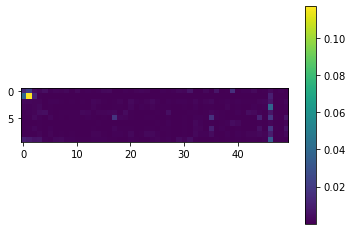

In [6]:
# Verify plotting works
plt.imshow(first_layer[0,0,:10,:50].detach().numpy(), interpolation="none")
plt.colorbar()
plt.show()

In [7]:
sum(result.cross_attentions[0][0,0,0,:])

tensor(1.0000, grad_fn=<AddBackward0>)

In [8]:
subwords_input = tokenizer.convert_ids_to_tokens(model_inputs["input_ids"][0])
print(subwords_input)

['▁<extra_id_0>', '▁<extra_id_1>', '▁', 'Eine', '▁Blum', 'e', '▁(', 'von', '▁alt', 'hoch', 'deutsch', '▁blu', 'oma', ',', '▁von', '▁indo', 'german', 'isch', '▁b', 'hlo', ',', '▁"', 'bl', 'ühen', ',', '▁zum', '▁Vor', 'schein', '▁kommen', '")', '▁be', 'zeichnet', '▁in', '▁der', '▁Alltag', 's', 'sprache', '▁', 'ent', 'weder', '▁eine', '▁B', 'lüten', 'pflanz', 'e', ',', '▁die', '▁', 'größe', 're', ',', '▁in', 's', '▁Auge', '▁fa', 'llende', '▁B', 'lüten', '▁"', 'her', 'vor', 'bring', 't', '",', '▁oder', '▁eine', '▁"', 'einzel', 'ne', '▁B', 'lüt', 'e', '▁', 'einer', '▁Blum', 'e', '▁mit', '▁S', 'tiel', '"', '▁oder', '▁wird', '▁als', '▁Kurz', 'form', '▁für', '▁Blumen', 'stock', '▁', 'verwend', 'et', '.', '▁<extra_id_1>', '▁Sie', '▁', 'dient', '▁of', 't', '▁als', '▁Schmuck', ',', '▁z', '.', '▁B', '.', '▁als', '▁Schnitt', 'blu', 'me', '▁in', '▁', 'einem', '▁Blumen', 'stra', 'uß', ',', '▁als', '▁Blumen', 'kran', 'z', '▁oder', '▁Blumen', 'ge', 'binde', '.', '▁<extra_id_1>', '▁In', '▁der', '▁Bild',

In [9]:
subwords_output = tokenizer.convert_ids_to_tokens(decoder_inputs["input_ids"][0])
print(subwords_output)

['<pad>', '▁<extra_id_1>', '▁', 'Eine', '▁Blum', 'e', '▁ist', '▁der', '▁', 'farbig', 'e', '▁Teil', '▁', 'einer', '▁Pflanze', '.', '▁<extra_id_1>', '▁', 'Eine', '▁Blum', 'e', '▁ist', '▁eigen', 'tlich', '▁eine', '▁B', 'lüt', 'e', '.', '▁<extra_id_1>', '▁In', '▁der', '▁B', 'lüt', 'e', '▁', 'bilden', '▁sich', '▁die', '▁', 'Samen', '.', '▁<extra_id_1>', '▁Die', '▁meist', 'en', '▁Blumen', '▁', 'brauche', 'n', '▁In', 's', 'ekten', ',', '▁wel', 'che', '▁die', '▁B', 'estä', 'ubung', '▁über', 'nehmen', '.', '▁<extra_id_1>', '▁So', '▁können', '▁sich', '▁dann', '▁', 'Samen', '▁', 'bilden', '.', '▁<extra_id_1>', '▁Die', '▁Blumen', '▁sind', '▁', 'farbig', ',', '▁dami', 't', '▁sie', '▁die', '▁In', 's', 'ekten', '▁', 'besser', '▁an', 'locken', '▁können', '.', '▁<extra_id_1>', '▁', 'Auch', '▁die', '▁Menschen', '▁freu', 'en', '▁sich', '▁über', '▁Blumen', '.', '▁<extra_id_1>', '▁Sie', '▁haben', '▁des', 'halb', '▁Blumen', '▁', 'auch', '▁gez', 'üchte', 't', ',', '▁dami', 't', '▁sie', '▁immer', '▁', 'größe'

In [10]:
def get_relevant_indices(subword_tokens, sentence_separator="<extra_id_1>"):
    """
    Assumes the input is padded with <extra_id_0>/<pad> and another <extra_id_1>.
    Also assumes <extra_id_1> as separators
    """
    return [idx for idx, subword in enumerate(subword_tokens) if sentence_separator in subword] + [len(subword_tokens) - 1]

def aggregate_matrix_into_sentence_based(attn_matrix, in_indices, out_indices):
    res = np.zeros([len(in_indices) - 1, len(out_indices) - 1])
    
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            res[i, j] = np.sum(attn_matrix[0, 0, out_indices[j]:out_indices[j+1], in_indices[i]:in_indices[i+1]])
    
    return res

In [11]:
input_indices = get_relevant_indices(subwords_input)
print(input_indices)
output_indices = get_relevant_indices(subwords_output)
print(output_indices)

[1, 92, 125, 147, 179, 245, 265, 292, 308, 340, 368, 389, 405, 433, 449, 468, 495, 513, 524, 604]
[1, 16, 29, 42, 63, 73, 93, 104, 130, 143, 158]


In [60]:
# first_layer = first_layer.detach().numpy()
# all_layers = np.concatenate([layer.detach().numpy() for layer in result.cross_attentions], axis=0)
last_layers = np.concatenate([layer.detach().numpy() for layer in result.cross_attentions[-1:]], axis=0)

In [61]:
all_layers = last_layers[:, 2:3, :, :]
all_layers.shape

(1, 1, 159, 605)

In [62]:
sentence_attentions = aggregate_matrix_into_sentence_based(all_layers, input_indices, output_indices)
print(sentence_attentions)

[[2.17751908 1.67349648 1.87928009 2.98358846 1.47779834 2.91602135
  1.76805377 4.428298   1.87299562 2.23171854]
 [0.43039858 0.49987692 0.42346793 0.62148035 0.33782685 0.6046502
  0.34467649 0.72687912 0.4193731  0.33621463]
 [0.37370834 0.29381114 0.2752544  0.43119597 0.25582522 0.49955171
  0.2567102  0.6142962  0.38014275 0.41069543]
 [0.9373256  0.98587328 0.64050233 0.91401756 0.47440317 0.86599427
  0.37211788 1.02441502 0.68887442 0.74354208]
 [2.02510595 2.19879627 1.66544759 2.59642911 1.04005146 2.07077885
  0.94247401 2.80840445 1.65408123 1.85560548]
 [0.62097061 0.72639179 0.47342545 0.78969175 0.24661759 0.47792834
  0.22467268 0.49768457 0.39940837 0.37083265]
 [0.16283366 0.21035539 0.19519018 0.34923744 0.15949672 0.2558009
  0.17321719 0.32502818 0.23877002 0.17617859]
 [0.79259288 1.03370774 0.5497086  0.79966462 0.24556215 0.55241942
  0.23859124 0.56760943 0.44259751 0.53018779]
 [0.51110131 0.37678874 0.43976486 1.00897813 0.33397114 1.04826117
  0.60160011 1

In [63]:
sentence_attentions[:, 0].sum()

13.584490329027176

In [64]:
sentence_attentions.shape

(19, 10)

In [65]:
normalized_sentence_attentions = sentence_attentions / np.sum(sentence_attentions, axis=0)[None, :]
print(normalized_sentence_attentions)

[[0.1602945  0.13569828 0.15780792 0.1480239  0.16424504 0.154896
  0.17082312 0.18345077 0.15137774 0.15152146]
 [0.03168309 0.04053336 0.03555968 0.03083332 0.03754666 0.03211838
  0.03330143 0.03011237 0.03389423 0.02282713]
 [0.02750993 0.02382417 0.02311381 0.0213928  0.02843285 0.02653566
  0.02480243 0.0254484  0.03072359 0.02788397]
 [0.06899969 0.0799412  0.05378461 0.04534689 0.05272598 0.04600071
  0.03595272 0.04243836 0.05567565 0.05048243]
 [0.14907486 0.1782931  0.13985186 0.12881588 0.1155931  0.1099976
  0.09105852 0.11634356 0.13368482 0.12598544]
 [0.04571173 0.0589007  0.03975474 0.03917875 0.0274095  0.02538705
  0.02170708 0.02061754 0.03228066 0.0251775 ]
 [0.01198673 0.01705702 0.01639061 0.01732662 0.01772674 0.01358788
  0.01673563 0.01346492 0.01929768 0.01196156]
 [0.05834543 0.08381993 0.04616043 0.03967353 0.0272922  0.02934394
  0.02305184 0.02351431 0.03577126 0.03599685]
 [0.03762389 0.03055255 0.03692817 0.05005814 0.03711813 0.05568253
  0.05812448 0.

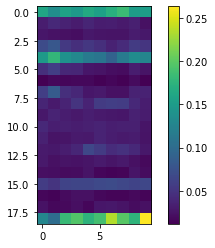

In [66]:
plt.imshow(normalized_sentence_attentions, interpolation="none")
plt.colorbar()
plt.show()

In [67]:
np.concatenate([layer.detach().numpy() for layer in result.cross_attentions], axis=0).shape

(8, 6, 159, 605)

In [68]:
clean_text = [line.strip("\n ") for line in sample['wiki_sentences'] if line.strip("\n ") and not line.startswith("=")]

for col in range(normalized_sentence_attentions.shape[1]):
    print(col)
    print(np.argmax(normalized_sentence_attentions[:, col]))
    print(clean_text[np.argmax(normalized_sentence_attentions[:, col])])

0
0
Eine Blume (von althochdeutsch bluoma, von indogermanisch bhlo, "blühen, zum Vorschein kommen") bezeichnet in der Alltagssprache entweder eine Blütenpflanze, die größere, ins Auge fallende Blüten "hervorbringt", oder eine "einzelne Blüte einer Blume mit Stiel" oder wird als Kurzform für Blumenstock verwendet.
1
4
Während die Blume (als Einzelblüte oder Blütenstand) über ihre Funktion bei der Bestäubung definiert ist, ist eine Blüte (als gestauchter Spross mit metamorphosierten Blättern) ein durch die Morphologie eindeutig definierter Begriff.
2
18
Die größte Blume der Erde wird von der Titanenwurz (Amorphophallus titanum) gebildet und wird über zwei Meter hoch, die größte Blüte der Erde (Rafflesia arnoldii) wird dagegen von einer Pflanzenart der Familie der Rafflesiengewächse gebildet und wird etwa einen Meter breit.
3
18
Die größte Blume der Erde wird von der Titanenwurz (Amorphophallus titanum) gebildet und wird über zwei Meter hoch, die größte Blüte der Erde (Rafflesia arnoldii)